#  Operationalize a Scikit-learn Model with Db2 v11.5	

Traditional scoring of machine learning models with data stored in a database often involves transferring the scoring data to a deployment system where the trained model is stored.  This can cause major challenges such as data transfer costs or data security requirements that can limit the kind or amount of data transferred from the database, such as personal identifiable information. Additionally, hardware and software roadblocks can ultimately prevent the transfer of large amounts of scoring data.

In this workshop we will develop a machine learning pipeline externally (i.e. on a local Jupyter notebook) and deploy it to Db2 for in-database scoring via SQL commands.

This solution allows users such as business analysts using SQL-based tools and applications to execute the machine learning pipeline by simply querying the Db2 database. 

This process ultimately keeps your scoring data secure and reduces data transfer latency, required compute power, complexity, and cost.

**Prerequisites**: If you are unfamiliar with the Jupyter Notebook environment, it is recommended to have gone through the [An Introduction to Jupyter Notebooks](./An_Introduction_to_Jupyter_Notebooks.ipynb) lab first

## Problem Statement

Consider we are on a plane heading towards our destination. We want to determine if the flight will be delayed arriving or not after it leaves the origin airport (binary classification):
* A delayed flight will be a flight that arrives late at its destination
* If the flight has any delays from its departure, but still arrives to its destination on time, it will not be considered a delayed flight
* A *canceled* flight is not a delayed flight as it never left nor arrived to its destination for whatever reason
* A *diverted* flight is not a delayed flight as it was diverted from its destination

To solve this problem, we will use historical US flight data from 2009-2018. We will then deploy our model to Db2 and make predictions on "new" data from 2020.

## Imports and Connection to Db2

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

# Model building
from sklearn.model_selection import train_test_split # Train-test split
from sklearn.impute import SimpleImputer # Missing values imputation
from sklearn.preprocessing import OneHotEncoder, StandardScaler # Feature scaling and one-hot encoding
from sklearn.compose import ColumnTransformer # For applying transformation objects
from sklearn.ensemble import RandomForestClassifier # Model
from sklearn.metrics import classification_report, confusion_matrix, f1_score # Model evaluation
from joblib import dump #Saving deployment assets

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,8)})
%config InlineBackend.figure_format = 'retina'

First load the Db2 magic functions and make a connection to our Db2 database.

In [2]:
%run db2.ipynb

Db2 Extensions Loaded.


In [3]:
%run connectiondb2ml.ipynb

Connection successful.


# Part I. Pipeline Development

## Read in Data

First we will read in our training data. Our training data contains historical flight data from 2009-2018 and contains the following data:
- `YEAR`: The year of the flight
- `QUARTER`: The yearly quarter
- `MONTH`: The month of the flight
- `DAYOFMONTH`: The day of the flight
- `DAYOFWEEK`: The day of the week the flight took place
- `UNIQUECARRIER`: The abbreviation code of the airline
- `ORIGIN`: The airport code of the departure airport
- `DEST`: The airport code of the arrival airport
- `CRSDEPTIME`: The scheduled departure time of the flight in the reservation system
- `DEPTIME`: The actual departure time of the flight
- `DEPDELAY`: The difference between the actual and scheduled departure times (minutes)
- `DEPDEL15`: Departure delay > 15 mins?
- `TAXIOUT`: Taxi out time (minutes)
- `WHEELSOFF`: Wheels of time (local time)
- `CRSARRTIME`: The scheduled arrival time of the flight in the reservation system
- `ARRTIME`: The actual arrival time of the flight
- `ARRDELAY`: The difference between the actual and scheduled arrival times (minutes)
- `CRSELAPSEDTIME`: The scheduled elapsed time of the flight in the reservation system
- `AIRTIME`: Flight time (minutes)
- `DISTANCEGROUP`: 250 mile distance interval group

![](media/ontime.png)

**Figure 1:** This figure shows the stages of a flight as described in the dataset

In [4]:
%%time
query = %sql SELECT * FROM ONTIME.TRAIN
df = pd.DataFrame(query)

CPU times: user 17.1 s, sys: 562 ms, total: 17.7 s
Wall time: 18.4 s


In [5]:
df.head()

,YEAR,QUARTER,MONTH,DAYOFMONTH,DAYOFWEEK,UNIQUECARRIER,ORIGIN,DEST,CRSDEPTIME,DEPTIME,DEPDELAY,DEPDEL15,TAXIOUT,WHEELSOFF,CRSARRTIME,ARRTIME,ARRDELAY,CRSELAPSEDTIME,AIRTIME,DISTANCEGROUP
0,2013,1,1,25,5,MQ,RDU,LGA,1100,1057,-3.0,0.0,12,1109,1230,1214,-16.0,90,62,2
1,2016,4,11,28,1,WN,BWI,PVD,1040,1034,-6.0,0.0,12,1046,1150,1138,-12.0,70,50,2
2,2012,2,4,26,4,US,PHX,ATL,910,905,-5.0,0.0,35,940,1554,1556,2.0,224,186,7
3,2010,2,6,17,4,EV,MEI,ATL,610,605,-5.0,0.0,4,609,824,806,-18.0,74,50,2
4,2016,2,4,1,5,DL,DAY,ATL,1032,1025,-7.0,0.0,17,1042,1209,1205,-4.0,97,78,2


In [6]:
print('The dataset has',df.shape[0],'rows and',df.shape[1],'columns.')

The dataset has 1000000 rows and 20 columns.


In [7]:
# Let's look at some summary statistics
df.describe()

,YEAR,QUARTER,MONTH,DAYOFMONTH,DAYOFWEEK,CRSDEPTIME,DEPTIME,DEPDELAY,DEPDEL15,TAXIOUT,WHEELSOFF,CRSARRTIME,ARRTIME,ARRDELAY,CRSELAPSEDTIME,AIRTIME,DISTANCEGROUP
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,999937.000000,999937.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,999960.000000,1000000.000000,1000000.000000,1000000.000000
mean,2013.193454,2.454007,6.362631,15.740650,3.936586,1325.589780,1332.387942,8.902103,0.180074,15.900501,1355.288523,1494.160152,1479.347530,4.669345,136.876648,109.661863,3.625980
std,2.784399,1.104170,3.394361,8.777538,1.989779,473.690848,486.288007,36.099259,0.384250,9.226515,487.585689,494.197406,513.180123,38.629338,73.472559,70.653527,2.338014
min,2009.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-62.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-103.000000,18.000000,7.000000,1.000000
25%,2011.000000,1.000000,3.000000,8.000000,2.000000,920.000000,925.000000,-5.000000,0.000000,10.000000,939.000000,1113.000000,1103.000000,-13.000000,84.000000,58.000000,2.000000
50%,2013.000000,2.000000,6.000000,16.000000,4.000000,1320.000000,1326.000000,-2.000000,0.000000,14.000000,1340.000000,1519.000000,1512.000000,-4.000000,118.000000,90.000000,3.000000
75%,2016.000000,3.000000,9.000000,23.000000,6.000000,1724.000000,1733.000000,7.000000,0.000000,19.000000,1747.000000,1911.000000,1911.000000,8.000000,167.000000,139.000000,5.000000
max,2018.000000,4.000000,12.000000,31.000000,7.000000,2359.000000,2400.000000,1767.000000,1.000000,232.000000,2400.000000,2400.000000,2400.000000,1794.000000,700.000000,703.000000,11.000000


## Data Preparation

### Create Target variable
We will use the `ArrDelay` variable to create our target variable `FlightStatus`:
- 0 = on time or early
- 1 = delayed

Let's first check for any missing values in this column

In [8]:
# Count the number of missing values
df['ARRDELAY'].isna().sum()

40

Lets investigate why these values are NA

In [9]:
# Create a temporary dataframe that includes rows where "ARRDELAY" is missing
tmp = df[df['ARRDELAY'].isna()]
tmp[['CRSARRTIME','ARRTIME','ARRDELAY']].head(10)

,CRSARRTIME,ARRTIME,ARRDELAY
13340,1420,1420,NaN
86805,1629,1629,NaN
131746,2145,2145,NaN
140634,1048,1048,NaN
154164,1508,1508,NaN
188721,1203,1203,NaN
225114,918,918,NaN
247128,1446,1446,NaN
258681,1515,1515,NaN
259485,2009,2009,NaN


We can see that these flights infact arrived on time: `CRSArrTime` = `ArrTime`. So we can replace these missing values in `ArrDelay` with 0

In [10]:
# Fill in missing values with 0
df['ARRDELAY']=df['ARRDELAY'].fillna(0)

We are now ready to create our target variable

In [11]:
# Create our target variable:
# 0 = on time or early
# 1 = delayed
target = 'FLIGHTSTATUS'
status = []
for val in df['ARRDELAY']:
    if val <=0:
        status.append(0)
    else:
        status.append(1) 

df[target] = status

In [12]:
# Let's look at the distribution of our target variable
df[target].value_counts(normalize=True)

0    0.624554
1    0.375446
Name: FLIGHTSTATUS, dtype: float64

We can see our dataset is slightly imbalanced with 62% of records being flights that are on time or early, and 38% of flights being delayed

In [13]:
df.head()

,YEAR,QUARTER,MONTH,DAYOFMONTH,DAYOFWEEK,UNIQUECARRIER,ORIGIN,DEST,CRSDEPTIME,DEPTIME,DEPDELAY,DEPDEL15,TAXIOUT,WHEELSOFF,CRSARRTIME,ARRTIME,ARRDELAY,CRSELAPSEDTIME,AIRTIME,DISTANCEGROUP,FLIGHTSTATUS
0,2013,1,1,25,5,MQ,RDU,LGA,1100,1057,-3.0,0.0,12,1109,1230,1214,-16.0,90,62,2,0
1,2016,4,11,28,1,WN,BWI,PVD,1040,1034,-6.0,0.0,12,1046,1150,1138,-12.0,70,50,2,0
2,2012,2,4,26,4,US,PHX,ATL,910,905,-5.0,0.0,35,940,1554,1556,2.0,224,186,7,1
3,2010,2,6,17,4,EV,MEI,ATL,610,605,-5.0,0.0,4,609,824,806,-18.0,74,50,2,0
4,2016,2,4,1,5,DL,DAY,ATL,1032,1025,-7.0,0.0,17,1042,1209,1205,-4.0,97,78,2,0


#### DepDelay
Let's do the same missing values investigation with `DepDelay`

In [14]:
# Count the number of missing values
df['DEPDELAY'].isna().sum()

63

In [15]:
# Create a temporary dataframe that includes rows where "DEPDELAY" is missing
tmp = df[df['DEPDELAY'].isna()]
tmp[['CRSDEPTIME','DEPTIME','DEPDELAY','DEPDEL15']].head(10)

,CRSDEPTIME,DEPTIME,DEPDELAY,DEPDEL15
4297,1430,1430,NaN,NaN
15993,809,809,NaN,NaN
57061,602,602,NaN,NaN
61400,1735,1735,NaN,NaN
69982,2015,2015,NaN,NaN
71391,1427,1427,NaN,NaN
85145,630,630,NaN,NaN
107994,2000,2000,NaN,NaN
113096,1457,1457,NaN,NaN
115056,1926,1926,NaN,NaN


We can see that these flights infact departed on time: `CRSDepTime` = `DepTime`. So we can replace these missing values in `DepDelay` and `DepDel15` with 0

In [16]:
# Fill in missing values with 0
df['DEPDELAY']=df['DEPDELAY'].fillna(0)
df['DEPDEL15']=df['DEPDEL15'].fillna(0)

#### Drop unneeded columns

We can drop the following columns:
- `DEPTIME`: Will use the DepDelay instead
- `ARRDELAY`: Will use the target variable instead
- `ARRTIME`: Will use the CRSArrTime instead

In [17]:
# Drop columns that are no longer needed
cols_to_drop=['DEPTIME','ARRDELAY','ARRTIME']
df=df.drop(cols_to_drop,axis=1)

In [18]:
df.head()

,YEAR,QUARTER,MONTH,DAYOFMONTH,DAYOFWEEK,UNIQUECARRIER,ORIGIN,DEST,CRSDEPTIME,DEPDELAY,DEPDEL15,TAXIOUT,WHEELSOFF,CRSARRTIME,CRSELAPSEDTIME,AIRTIME,DISTANCEGROUP,FLIGHTSTATUS
0,2013,1,1,25,5,MQ,RDU,LGA,1100,-3.0,0.0,12,1109,1230,90,62,2,0
1,2016,4,11,28,1,WN,BWI,PVD,1040,-6.0,0.0,12,1046,1150,70,50,2,0
2,2012,2,4,26,4,US,PHX,ATL,910,-5.0,0.0,35,940,1554,224,186,7,1
3,2010,2,6,17,4,EV,MEI,ATL,610,-5.0,0.0,4,609,824,74,50,2,0
4,2016,2,4,1,5,DL,DAY,ATL,1032,-7.0,0.0,17,1042,1209,97,78,2,0


In [19]:
print('The dataset now has',df.shape[0],'rows and',df.shape[1],'columns.')

The dataset now has 1000000 rows and 18 columns.


### Train-Test Split

Before we continue with further data preparation steps, we will first split our dataset into a training and test set using an 80/20 split. We will use our training data to develop our model and our test set to evaluate the model's performance.

In [20]:
# Train test split
X = df.drop(target,axis=1)
y = df[target]

# # 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [21]:
print('The training dataset has',X_train.shape[0],'rows and',X_train.shape[1],'columns.')

The training dataset has 800000 rows and 17 columns.


In [22]:
print('The test dataset has',X_test.shape[0],'rows and',X_test.shape[1],'columns.')

The test dataset has 200000 rows and 17 columns.


### Missing Values

Most machine learning algorithms cannot work with missing values. Therefore, it is important to identify any missing values and then to impute (i.e., replace) any missing values in our dataset.

In [23]:
# Calculate percentage of missing values and show top 10 columns with most missing values
percent_missing = X_train.isna().sum() * 100 / len(X_train)
percent_missing.sort_values(ascending=False, inplace=True)
percent_missing[:10]

DISTANCEGROUP    0.0
DEST             0.0
QUARTER          0.0
MONTH            0.0
DAYOFMONTH       0.0
DAYOFWEEK        0.0
UNIQUECARRIER    0.0
ORIGIN           0.0
CRSDEPTIME       0.0
AIRTIME          0.0
dtype: float64

There are no missing values, so no imputation is required

### Convert Time Values
We will convert the timestamp values in `CRSDepTime`,`WheelsOff`, and `CRSArrTime` to a categorical value split into 4 quarters of the day. We will split `CRSElapsedTime` into 30 min segments.

In [24]:
# Convert time values into categorical values
X_train['CRSDEPTIME'] = np.ceil(X_train['CRSDEPTIME']/600).apply(int)
X_train['WHEELSOFF'] = np.ceil(X_train['WHEELSOFF']/600).apply(int) 
X_train['CRSARRTIME'] = np.ceil(X_train['CRSARRTIME']/600).apply(int)
X_train['CRSELAPSEDTIME']=np.ceil(X_train['CRSELAPSEDTIME']/30).apply(int)

In [25]:
X_train.head()

,YEAR,QUARTER,MONTH,DAYOFMONTH,DAYOFWEEK,UNIQUECARRIER,ORIGIN,DEST,CRSDEPTIME,DEPDELAY,DEPDEL15,TAXIOUT,WHEELSOFF,CRSARRTIME,CRSELAPSEDTIME,AIRTIME,DISTANCEGROUP
566853,2017,3,7,28,5,WN,FLL,MSY,2,-3.0,0.0,41,2,2,4,89,3
382311,2014,4,11,10,1,AS,BET,ANC,2,-8.0,0.0,4,2,2,3,63,2
241519,2018,2,5,6,7,AA,CVG,DFW,3,2.0,0.0,14,3,3,6,111,4
719220,2015,2,6,21,7,AS,SEA,SFO,3,21.0,1.0,20,3,3,5,99,3
905718,2010,4,12,31,5,F9,DEN,LAS,2,32.0,1.0,83,2,2,4,72,3


### Feature Scaling
We will scale our continuous numerical columns: `AirTime`,`TaxiOut`,`DepDelay`.

Most machine learning algorithms do not perform well when the numerical attributes in the data have very different scales (i.e., large range of possible values). It is important to make sure that the numerical features in our dataset have similar scales. A standardized value z of an input feature x is calculated as:

z = (x - u) / s

where u is the mean of the training samples and s is the standard deviation of the training samples.

In [26]:
# Scale continuous numerical columns
cols_to_scale=['AIRTIME','TAXIOUT','DEPDELAY']
scaler = ColumnTransformer(
[('scaler', StandardScaler(),cols_to_scale)],
remainder='passthrough')

In [27]:
trained_scaler = scaler.fit(X_train)

In [28]:
# Apply standardization and return a dataframe
col_names = X_train.columns.tolist()
X_train_trsf = pd.DataFrame(trained_scaler.transform(X_train))
X_train_trsf.columns=cols_to_scale + [col for col in col_names if col not in cols_to_scale]
X_train_trsf.index=X_train.index

#### Hands-On Exercise 1

While performing data transformations, it is always important to validate that the transformations were performed correctly.

**Using pandas DataFrame .head() and/or .tail() method, visually validate that our feature scaling was performed correctly.**


**Hint**: The syntax will be similar to `df.head()` or `df.tail()`, where `df` is the name of the dataframe.

**Solution:**

In [29]:
X_train_trsf.head()

,AIRTIME,TAXIOUT,DEPDELAY,YEAR,QUARTER,MONTH,DAYOFMONTH,DAYOFWEEK,UNIQUECARRIER,ORIGIN,DEST,CRSDEPTIME,DEPDEL15,WHEELSOFF,CRSARRTIME,CRSELAPSEDTIME,DISTANCEGROUP
566853,-0.293098,2.72063,-0.329485,2017,3,7,28,5,WN,FLL,MSY,2,0,2,2,4,3
382311,-0.66066,-1.29076,-0.467928,2014,4,11,10,1,AS,BET,ANC,2,0,2,2,3,2
241519,0.0179163,-0.206598,-0.191043,2018,2,5,6,7,AA,CVG,DFW,3,0,3,3,6,4
719220,-0.151728,0.443898,0.335037,2015,2,6,21,7,AS,SEA,SFO,3,1,3,3,5,3
905718,-0.533427,7.27411,0.63961,2010,4,12,31,5,F9,DEN,LAS,2,1,2,2,4,3


### One-Hot Encoding

The values in `UNIQUECARRIER`, `ORIGIN`, and `DEST` need to be converted into categorical columns

Most machine learning algorithms prefer to work with numbers rather than text values. A common solution is to create one binary attribute per category: one attribute equal to 1 when the category is “LAX” (and 0 otherwise), another attribute equal to 1 when the category is “JFK” (and 0 otherwise), and so on. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold).

In [30]:
# Calculate number of unique values in each of these columns
print('Number of unique values in UNIQUECARRIER:',X_train_trsf['UNIQUECARRIER'].nunique())
print('Number of unique values in ORIGIN:',X_train_trsf['ORIGIN'].nunique())
print('Number of unique values in DEST:',X_train_trsf['DEST'].nunique())

Number of unique values in UNIQUECARRIER: 23
Number of unique values in ORIGIN: 365
Number of unique values in DEST: 367


Clearly, we can't apply one-hot encoding directly to these columns as we would be adding >750 new columns! Instead we will select the top 10 most common occurences in these columns as our labels

In [31]:
# Create a list of the top 10 occurences in each column
top_10_airlines = X_train_trsf['UNIQUECARRIER'].value_counts().index[:10].tolist()
top_10_origin = X_train_trsf['ORIGIN'].value_counts().index[:10].tolist()
top_10_dest = X_train_trsf['DEST'].value_counts().index[:10].tolist()

In [32]:
# Replace values not in the top 10 list with "Other"
X_train_trsf['UNIQUECARRIER'] = np.where(~X_train_trsf['UNIQUECARRIER'].isin(top_10_airlines), 
                                                       'Other_Airline', X_train_trsf['UNIQUECARRIER'])
X_train_trsf['ORIGIN'] = np.where(~X_train_trsf['ORIGIN'].isin(top_10_origin), 
                                                       'Other_Origin', X_train_trsf['ORIGIN'])
X_train_trsf['DEST'] = np.where(~X_train_trsf['DEST'].isin(top_10_dest), 
                                                       'Other_Dest', X_train_trsf['DEST'])


In [33]:
# Confirm it worked
print('Number of unique values in UNIQUECARRIER:',X_train_trsf['UNIQUECARRIER'].nunique())
print('Number of unique values in ORIGIN:',X_train_trsf['ORIGIN'].nunique())
print('Number of unique values in DEST:',X_train_trsf['DEST'].nunique())

Number of unique values in UNIQUECARRIER: 11
Number of unique values in ORIGIN: 11
Number of unique values in DEST: 11


In [34]:
X_train_trsf.head()

,AIRTIME,TAXIOUT,DEPDELAY,YEAR,QUARTER,MONTH,DAYOFMONTH,DAYOFWEEK,UNIQUECARRIER,ORIGIN,DEST,CRSDEPTIME,DEPDEL15,WHEELSOFF,CRSARRTIME,CRSELAPSEDTIME,DISTANCEGROUP
566853,-0.293098,2.72063,-0.329485,2017,3,7,28,5,WN,Other_Origin,Other_Dest,2,0,2,2,4,3
382311,-0.66066,-1.29076,-0.467928,2014,4,11,10,1,AS,Other_Origin,Other_Dest,2,0,2,2,3,2
241519,0.0179163,-0.206598,-0.191043,2018,2,5,6,7,AA,Other_Origin,DFW,3,0,3,3,6,4
719220,-0.151728,0.443898,0.335037,2015,2,6,21,7,AS,Other_Origin,SFO,3,1,3,3,5,3
905718,-0.533427,7.27411,0.63961,2010,4,12,31,5,Other_Airline,DEN,LAS,2,1,2,2,4,3


We are now ready to perform one-hot encoding

In [35]:
# Perform one-hot encoding
cols_to_encode = ['UNIQUECARRIER','ORIGIN','DEST']
encoder = ColumnTransformer(transformers=[
    ('encoder',OneHotEncoder(handle_unknown='ignore'),cols_to_encode)],
    remainder='passthrough')

In [36]:
trained_encoder = encoder.fit(X_train_trsf)

In [37]:
X_train_trsf = trained_encoder.transform(X_train_trsf)

In [38]:
print('The training now dataset has',X_train_trsf.shape[0],'rows and',X_train_trsf.shape[1],'columns.')

The training now dataset has 800000 rows and 47 columns.


In [39]:
# Get the feature names after fitting the encoder - this will be used to determine the model's feature importance
feature_names=trained_encoder.get_feature_names()

## Transform X_test

We now need to apply the same transformations to our test set

In [40]:
# Convert time to categorical variable
X_test['CRSDEPTIME'] = np.ceil(X_test['CRSDEPTIME']/600).apply(int)
X_test['WHEELSOFF'] = np.ceil(X_test['WHEELSOFF']/600).apply(int) 
X_test['CRSARRTIME'] = np.ceil(X_test['CRSARRTIME']/600).apply(int)
X_test['CRSELAPSEDTIME']=np.ceil(X_test['CRSELAPSEDTIME']/30).apply(int)

In [41]:
# Feature Scaling
col_names = X_test.columns.tolist()
X_test_trsf = pd.DataFrame(trained_scaler.transform(X_test))
X_test_trsf.columns=cols_to_scale + [col for col in col_names if col not in cols_to_scale]
X_test_trsf.index=X_test.index

In [42]:
# Replace values not in the top 10 list with "Other"
X_test_trsf['UNIQUECARRIER'] = np.where(~X_test_trsf['UNIQUECARRIER'].isin(top_10_airlines), 
                                                       'Other_Airline', X_test_trsf['UNIQUECARRIER'])
X_test_trsf['ORIGIN'] = np.where(~X_test_trsf['ORIGIN'].isin(top_10_origin), 
                                                       'Other_Origin', X_test_trsf['ORIGIN'])
X_test_trsf['DEST'] = np.where(~X_test_trsf['DEST'].isin(top_10_dest), 
                                                       'Other_Dest', X_test_trsf['DEST'])


In [43]:
# Perform one-hot encoding
X_test_trsf = trained_encoder.transform(X_test_trsf)

In [44]:
print('The test dataset has',X_test_trsf.shape[0],'rows and',X_test_trsf.shape[1],'columns.')

The test dataset has 200000 rows and 47 columns.


## Model Training

### Random Forest

Suppose you ask a complex question to thousands of random people, then aggregate their answers. In many cases you will find that this aggregated answer is better than an expert’s answer. This is called the *wisdom of the crowd*. Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an *ensemble*; thus, this technique is called *Ensemble Learning*. For example, you can train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, you just obtain the predictions of all individual trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called a **Random Forest**, and despite its simplicity, this is one of the most powerful Machine Learning algorithms available today.

We will train a random forest classifer using the default values and setting the `class_weight` parameter to "balanced" due to our imbalanced training dataset.

In [45]:
# Base model
rf = RandomForestClassifier(random_state=42,class_weight='balanced')

In [46]:
%%time
trained_rf = rf.fit(X_train_trsf,y_train)

CPU times: user 3min 5s, sys: 1 s, total: 3min 6s
Wall time: 3min 7s


In [47]:
# Make predictions on the test set
y_pred = trained_rf.predict(X_test_trsf)

We will use the F1 score (harmonic mean of Precision and Recall) as our metric for evaluating model performance. An F1-Score of 1.0, indicates perfect precision and recall, and the lowest possible value is 0, if either the precision or the recall is zero.

Precision is the number of true positive results divided by the number of all positive results, including those not identified correctly, and the recall is the number of true positive results divided by the number of all samples that should have been identified as positive.

The F1 score can be expressed as

$\frac{TP}{TP +\frac{1}{2}(FP+FN)}$,

where TP is the number of true positives, FP is the number of false positives, and FN is the number of false negatives

In [48]:
# Let's evaluate the model performance
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90    124825
           1       0.90      0.73      0.81     75175

    accuracy                           0.87    200000
   macro avg       0.88      0.84      0.85    200000
weighted avg       0.87      0.87      0.87    200000



Model F1 Score: 0.808


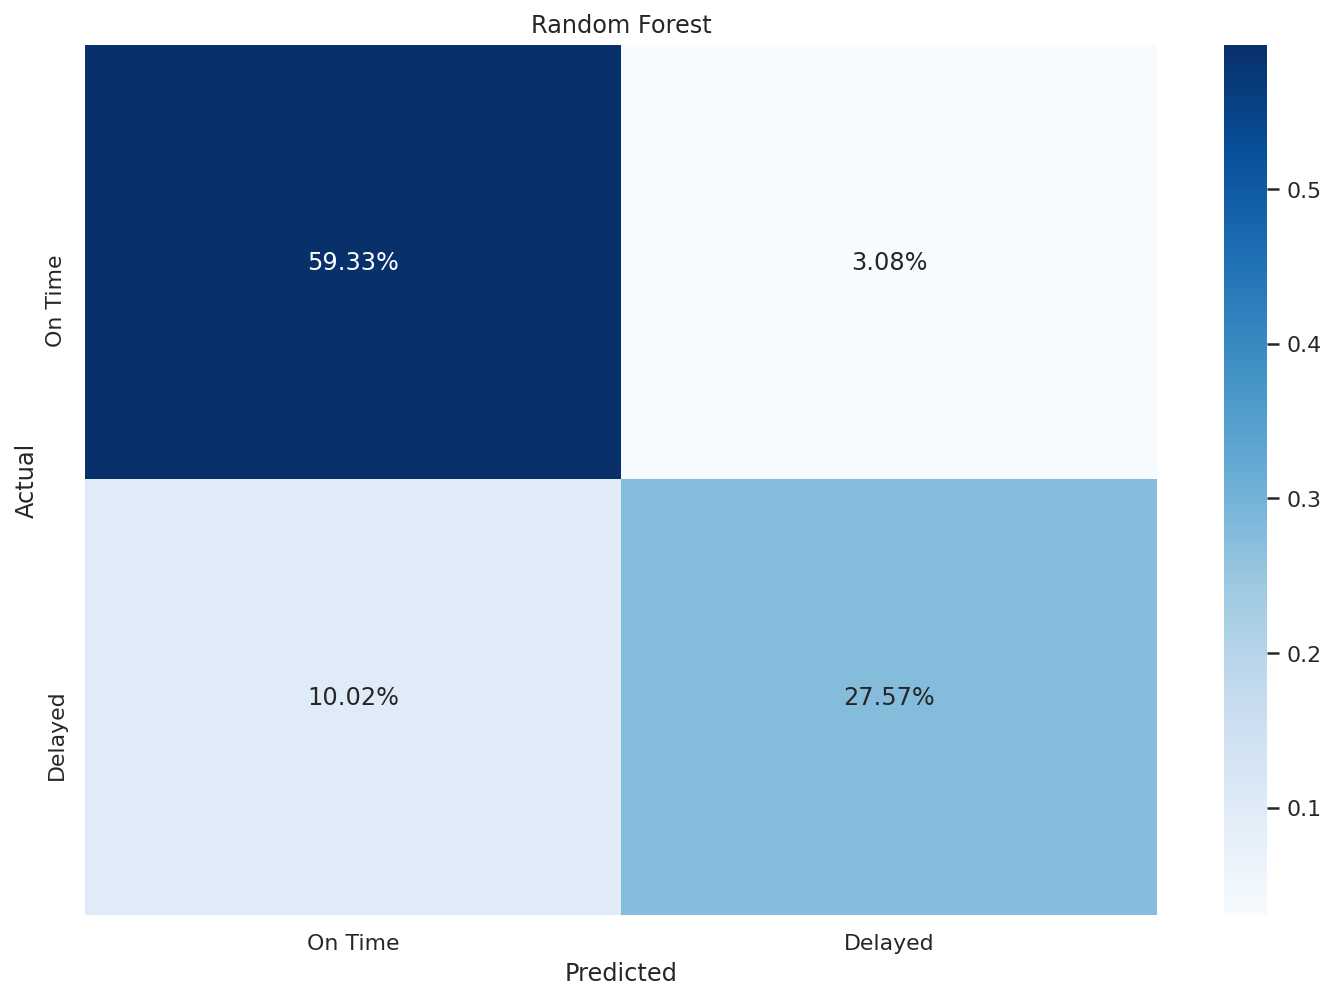

In [49]:
# Plot confusion matrix
print('Model F1 Score: %.3f' % f1_score(y_test,y_pred))

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',xticklabels=['On Time','Delayed'],yticklabels=['On Time','Delayed'])
plt.title('Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

We can also take a look at the features the model has deemed as important for determining if a flight will be delayed or on time.

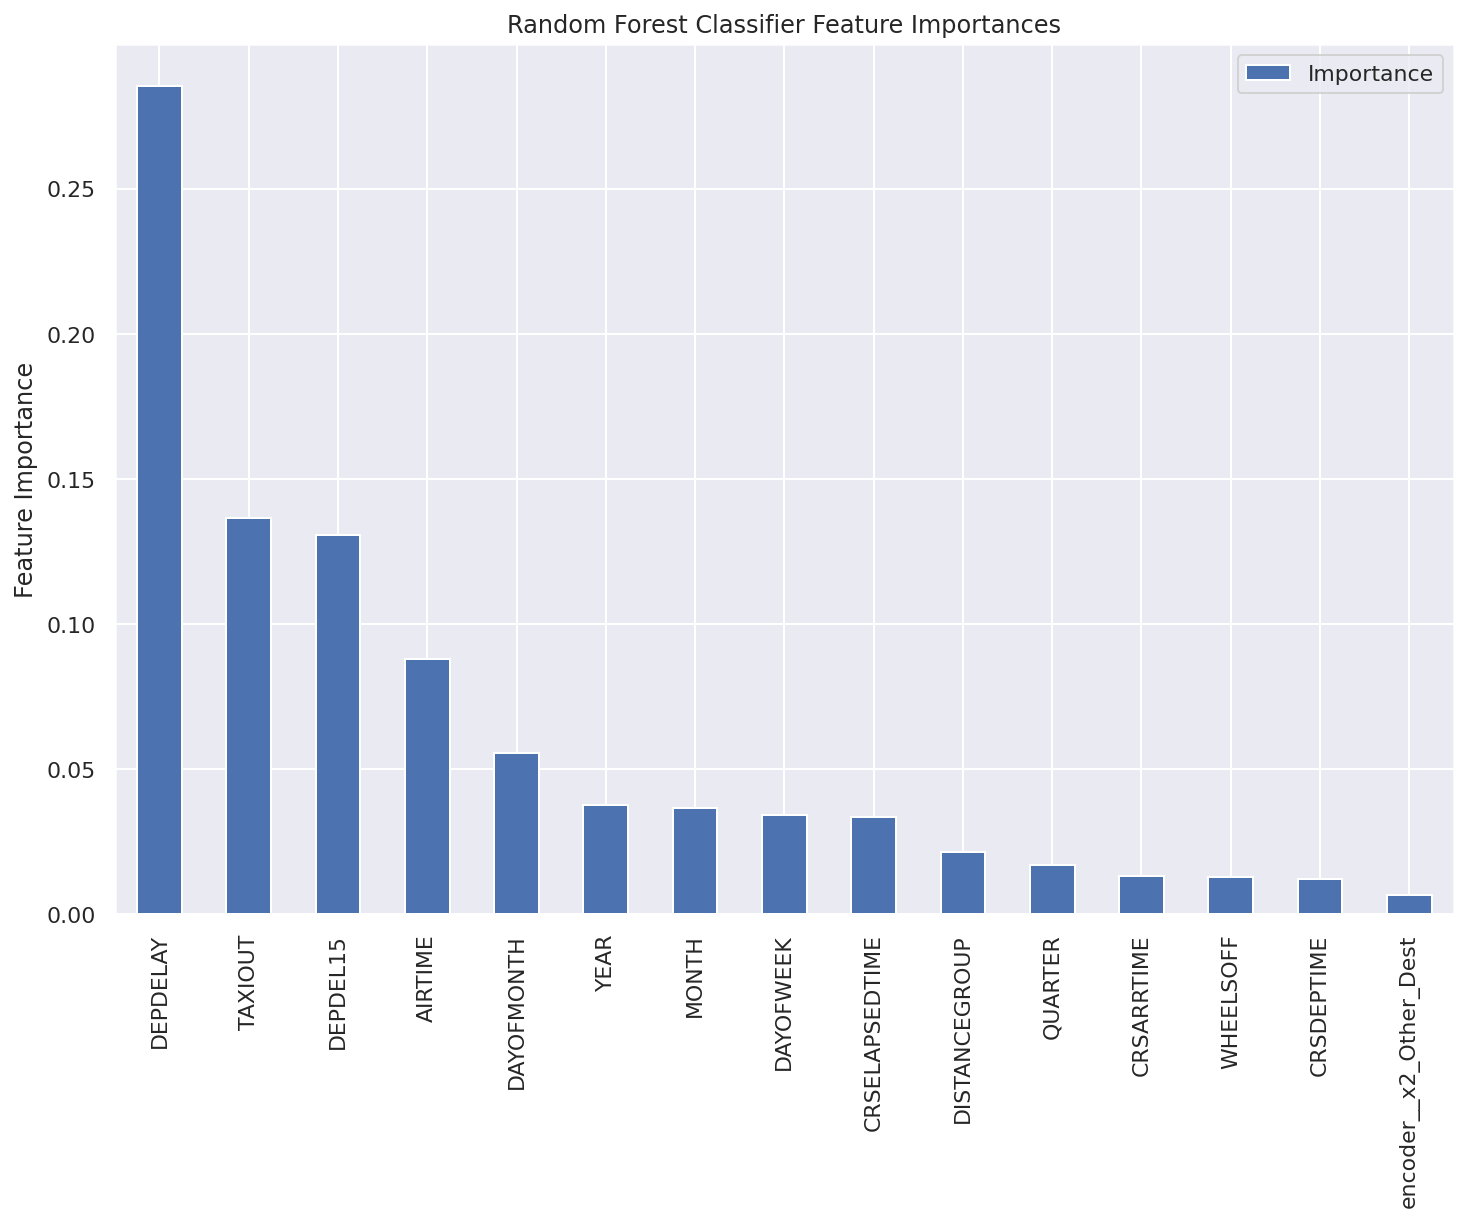

In [50]:
# Plot feature importances
feature_importances=pd.DataFrame(trained_rf.feature_importances_.flatten(), index=trained_encoder.get_feature_names(), 
                                 columns=['Importance'])
feature_importances.sort_values(by='Importance',ascending=False).head(15).plot.bar();
plt.ylabel('Feature Importance')
plt.title('Random Forest Classifier Feature Importances');

## Save Deployment Assets

We now need to save our deployment assets to the shared filesystem. They include:
- top 10 carriers, origin, and destinations
- trained scalar
- trained one-hot encoder
- trained model

In [51]:
# Save our deployment assets to the shared filesystem
dump(top_10_airlines,'../PYUDF/top_10_airlines.joblib')
dump(top_10_origin,'../PYUDF/top_10_origin.joblib')
dump(top_10_dest,'../PYUDF/top_10_dest.joblib')
dump(trained_scaler,'../PYUDF/trained_scaler.joblib')
dump(trained_encoder,'../PYUDF/trained_encoder.joblib')
dump(trained_rf,'../PYUDF/trained_rf.joblib')

['../PYUDF/trained_rf.joblib']

# Part II. Deploying the Pipeline to Db2

We are now ready to deploy our model to Db2 for in-database scoring.

We will:
1. Create a UDF source file
2. Register our Python UDF
3. Call our UDF with a SQL statement

Our UDTF (User Defined Table Function) has the following sections:
- **Initialization**: Define any static variables, load our deployment assets (e.g. model), and prepare for batch scoring
- **Data Preparation**: Perform the same data preparation steps we performed during model development
- **Model Scoring & Output**: Call our model to make predictions and return the results

Our UDTF will output the following:
- `DATE`: The date of the flight 
- `ORIGIN`: The origin airport
- `DEST`: The destination airport
- `CARRIER`: The airline code
- `CRSDEPTIME`: The scheduled departure time
- `CRSARRTIME`: The scheduled arrival time 
- `PREDICTION`: The prediction (0 = on time, 1 = delayed)
- `PROB_DELAYED`: The predicted probability that the flight will be delayed

![](media/udfdeployment.png)

**Figure 2**: This figure depicts how a UDF source file is created from the original pipeline code developed during the model development stage.

In [52]:
%%writefile ../PYUDF/myUDF.py

#Imports
import nzae
import pandas as pd
from joblib import load
import numpy as np


class full_pipeline(nzae.Ae):
    def _runUdtf(self):
        #####################
        ### INITIALIZATON ###
        #####################
        
        # Define static variables
        input_cols = ['YEAR','QUARTER', 'MONTH',
                      'DAYOFMONTH', 'DAYOFWEEK','UNIQUECARRIER',
                      'ORIGIN', 'DEST', 'CRSDEPTIME',
                      'DEPDELAY', 'DEPDEL15','TAXIOUT','WHEELSOFF',
                      'CRSARRTIME', 'CRSELAPSEDTIME', 'AIRTIME', 'DISTANCEGROUP']
        cols_to_scale=['AIRTIME','TAXIOUT','DEPDELAY']
        cols_to_encode = ['UNIQUECARRIER','ORIGIN','DEST']

        # Load deployment assets
        top_10_airlines= load('home/db2inst1/PYUDF/top_10_airlines.joblib')
        top_10_origin=load('home/db2inst1/PYUDF/top_10_origin.joblib')
        top_10_dest= load('home/db2inst1/PYUDF/top_10_dest.joblib')
        trained_scaler = load('home/db2inst1/PYUDF/trained_scaler.joblib')
        trained_encoder = load('home/db2inst1/PYUDF/trained_encoder.joblib')
        trained_rf = load('home/db2inst1/PYUDF/trained_rf.joblib')
     
        # Collect rows into a single batch
        batchsize = 10000
        rownum = 0
        row_list = []
        for row in self:
            row_list.append(row)
            rownum = rownum+1         

            if rownum==batchsize:
                ########################
                ### DATA PREPARATION ###
                ########################
                
                # Collect the rows into a dataframe
                df = pd.DataFrame(row_list, columns=input_cols)


                # Save the original datestring (yyyymmdd), ORIGIN, DEST, UNIQUECARRIER, CRSDEPTIME, CRSARRTIME
                # to return with the model prediction
                dates = [int(year + month + day) for year, month, day in 
                         zip(map(str,list(df['YEAR'])), map(str,["%02d" %i for i in list(df['MONTH'])]), 
                             map(str,["%02d" %i for i in list(df['DAYOFMONTH'])]))]
                origins = list(df['ORIGIN'])
                dests = list(df['DEST'])
                carriers = list(df['UNIQUECARRIER'])
                deptimes = list(df['CRSDEPTIME'])
                arrtimes = list(df['CRSARRTIME'])

                
                # Fill any missing values
                df['DEPDELAY']=df['DEPDELAY'].fillna(0)
                df['DEPDEL15']=df['DEPDEL15'].fillna(0)

                # Convert time values to categorical variable
                df['CRSDEPTIME'] = np.ceil(df['CRSDEPTIME']/600).apply(int)
                df['WHEELSOFF'] = np.ceil(df['WHEELSOFF']/600).apply(int) 
                df['CRSARRTIME'] = np.ceil(df['CRSARRTIME']/600).apply(int)
                df['CRSELAPSEDTIME']=np.ceil(df['CRSELAPSEDTIME']/30).apply(int)

                # Feature scaling
                col_names = df.columns.tolist()
                df_trsf = pd.DataFrame(trained_scaler.transform(df))
                df_trsf.columns=cols_to_scale + [col for col in col_names if col not in cols_to_scale]
                df_trsf.index=df.index

                # Replace values not in the top 10 list with "Other"
                df_trsf['UNIQUECARRIER'] = np.where(~df_trsf['UNIQUECARRIER'].isin(top_10_airlines), 
                                                                       'Other_Airline', df_trsf['UNIQUECARRIER'])
                df_trsf['ORIGIN'] = np.where(~df_trsf['ORIGIN'].isin(top_10_origin), 
                                                                       'Other_Origin', df_trsf['ORIGIN'])
                df_trsf['DEST'] = np.where(~df_trsf['DEST'].isin(top_10_dest), 
                                                                       'Other_Dest', df_trsf['DEST'])

                # One-hot encoding
                df_trsf = trained_encoder.transform(df_trsf)

                ##############################
                ### MODEL SCORING & OUTPUT ###
                ##############################
                
                # Call model to make prediction
                predictions = trained_rf.predict(df_trsf)
                
                # Calculate probability that flight will be delayed
                probability_delayed = trained_rf.predict_proba(df_trsf)[:,1]
                
                # Return the result
                for x in range(predictions.shape[0]):
                    self.output(int(dates[x]),str(origins[x]),str(dests[x]),str(carriers[x]),
                                int(deptimes[x]),int(arrtimes[x]),int(predictions[x]),
                                float(probability_delayed[x]))

                row_list = []
                rownum = 0
                
        self.done()
full_pipeline.run()

Overwriting ../PYUDF/myUDF.py


We are now ready to register our UDTF. We will provide it a name `FLIGHT_PREDICTER`, define the input datatypes, the definition of the table it outputs (i.e. column names and datatypes), and the path to our source file.

In [53]:
%%sql
CREATE OR REPLACE FUNCTION 
FLIGHT_PREDICTER(SMALLINT,SMALLINT,SMALLINT,SMALLINT,SMALLINT,VARCHAR(8),VARCHAR(3),
              VARCHAR(3),SMALLINT,SMALLINT,SMALLINT,SMALLINT,SMALLINT,SMALLINT,SMALLINT,
              SMALLINT,SMALLINT) 
RETURNS TABLE (DATE INTEGER,ORIGIN VARCHAR(3), DEST VARCHAR(3), CARRIER VARCHAR(3), 
CRSDEPTIME SMALLINT, CRSARRTIME SMALLINT,PREDICTION SMALLINT,PROB_DELAYED DOUBLE)
LANGUAGE PYTHON PARAMETER STYLE NPSGENERIC  FENCED  NOT THREADSAFE  NO FINAL CALL  DISALLOW PARALLEL  NO DBINFO  
DETERMINISTIC NO EXTERNAL ACTION CALLED ON NULL INPUT  
NO SQL EXTERNAL NAME 'home/db2inst1/PYUDF/myUDF.py'

Command completed.


With our UDTF source file created and our function registered, we can now call the Python UDTF to make predictions. We will create a table `ONTIME.PREDICTIONS` to store the results, and insert the output from our UDTF into that table. Recall that we will be making predictions on new flight data from 2020 (i.e., the model is using historical data to make predictions on future events).

In [54]:
%%sql
DROP TABLE IF EXISTS ONTIME.PREDICTIONS

Command completed.


In [55]:
%%sql
CREATE TABLE ONTIME.PREDICTIONS(DATE INTEGER,
                                ORIGIN VARCHAR(3), 
                                DEST VARCHAR(3),
                                CARRIER VARCHAR(3),
                                CRSDEPTIME SMALLINT, 
                                CRSARRTIME SMALLINT,
                                PREDICTION SMALLINT,
                                PROB_DELAYED DOUBLE)

Command completed.


In [56]:
%%time
%%sql
INSERT INTO ONTIME.PREDICTIONS(DATE,ORIGIN,DEST,CARRIER,CRSDEPTIME,CRSARRTIME,PREDICTION,PROB_DELAYED)
SELECT f.* from ONTIME.TEST i,
TABLE(FLIGHT_PREDICTER(i.YEAR, i.QUARTER, i.MONTH, 
                i.DAYOFMONTH, i.DAYOFWEEK,i.UNIQUECARRIER,
                i.ORIGIN, i.DEST, i.CRSDEPTIME,
                i.DEPDELAY, i.DEPDEL15,i.TAXIOUT,i.WHEELSOFF,
                i.CRSARRTIME, i.CRSELAPSEDTIME, i.AIRTIME, i.DISTANCEGROUP)) f

Command completed.
CPU times: user 7.08 ms, sys: 65.2 ms, total: 72.2 ms
Wall time: 3min 56s


Finally, we can query the `ONTIME.PREDICTIONS` table to look at the output.

In [57]:
query = %sql SELECT * FROM ONTIME.PREDICTIONS
result = pd.DataFrame(query)

In [58]:
# Lets look at the first 10 rows of our UDTF's output
result.head(10)

,DATE,ORIGIN,DEST,CARRIER,CRSDEPTIME,CRSARRTIME,PREDICTION,PROB_DELAYED
0,20201215,SFO,MIA,AA,2350,805,1,0.86
1,20200614,HOU,DCA,WN,2000,2355,1,0.77
2,20200627,DFW,PSP,AA,1655,1747,1,0.99
3,20200203,DFW,SLC,OO,1233,1425,1,0.89
4,20200108,PHX,ORD,AA,145,605,0,0.07
5,20201016,ORD,EWR,UA,1812,2132,0,0.07
6,20200914,ORD,BOS,AA,2155,100,1,0.94
7,20200609,PDX,PHX,WN,2005,2240,0,0.25
8,20200226,BOS,TPA,B6,2015,2335,0,0.35
9,20200608,BUF,BOS,B6,1510,1633,0,0.00


## Exercise: Build and deploy your own UDF

In this exercise you will deploy your own ML classification model. We will provide the steps to build and deploy the model, including any necessary data transformation steps. You will be responsible for filling the UDF template provided during the model deployment phase.

The dataset used is the famous IRIS dataset - it contains samples from each of three species of *Iris* flowers. (*Iris setosa*, *Iris virginica*, and *Iris versicolor*). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters.

In [59]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

# Model building
from sklearn.model_selection import train_test_split # Train-test split
from sklearn.impute import SimpleImputer # Missing values imputation
from sklearn.compose import ColumnTransformer # For applying transformation objects
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score # Model evaluation
from joblib import dump #Saving deployment assets

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,8)})
%config InlineBackend.figure_format = 'retina'

In [60]:
%run db2.ipynb

Db2 Extensions Loaded.


In [61]:
%run connectiondb2ml.ipynb

Connection successful.


#### Data Exploration

In [62]:
# Let's look at the training data
query = %sql SELECT * FROM ONTIME.IRIS_TRAIN
df = pd.DataFrame(query)
df.head(10)

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH,CLASS
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,NaN,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,NaN,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


In [63]:
# Train test split
target = "CLASS"
X = df.drop(target,axis=1)
y = df[target]

# # 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [64]:
print('The training dataset has',X_train.shape[0],'rows and',X_train.shape[1],'columns.')

The training dataset has 105 rows and 4 columns.


In [65]:
print('The test dataset has',X_test.shape[0],'rows and',X_test.shape[1],'columns.')

The test dataset has 45 rows and 4 columns.


#### Data Transformation

Let's check for missing values in our training and test sets, and perform imputation if necessary.

In [66]:
# Count the number of missing values in the training set
number_of_missing_vals = X_train.isna().sum()
number_of_missing_vals

SEPAL_LENGTH    4
SEPAL_WIDTH     3
PETAL_LENGTH    2
PETAL_WIDTH     5
dtype: int64

Next, let's perform missing value imputation

In [67]:
# Train an imputer to perform missing value imputation
from sklearn.impute import SimpleImputer
imputer= SimpleImputer(strategy='mean')
trained_imputer = imputer.fit(X_train)

# Transform the training set and return as a dataframe
X_train_trsf = pd.DataFrame(trained_imputer.transform(X_train),
                            columns=['SEPAL_LENGTH','SEPAL_WIDTH','PETAL_LENGTH','PETAL_WIDTH'])

Now, let's repeat these steps for our test set

In [68]:
# Let's take a look if our test set has any missing values
number_of_missing_vals = X_test.isna().sum()
number_of_missing_vals

SEPAL_LENGTH    1
SEPAL_WIDTH     3
PETAL_LENGTH    2
PETAL_WIDTH     1
dtype: int64

In [69]:
# Let's transform our test set before we make any predictions
X_test_trsf = trained_imputer.transform(X_test)

#### Model Training and Evaluation

We will train a simple decision tree model to predict the type of flower based on the sepal and petal length and width.

In [70]:
# Let's train a simple decision tree model
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
trained_dt = dt.fit(X_train_trsf,y_train)

In [71]:
y_test.value_counts(normalize=True)

Iris-setosa        0.422222
Iris-versicolor    0.288889
Iris-virginica     0.288889
Name: CLASS, dtype: float64

We next will make predictions on our test set and evaluate the performance of the model

Model F1 Score: 1.000


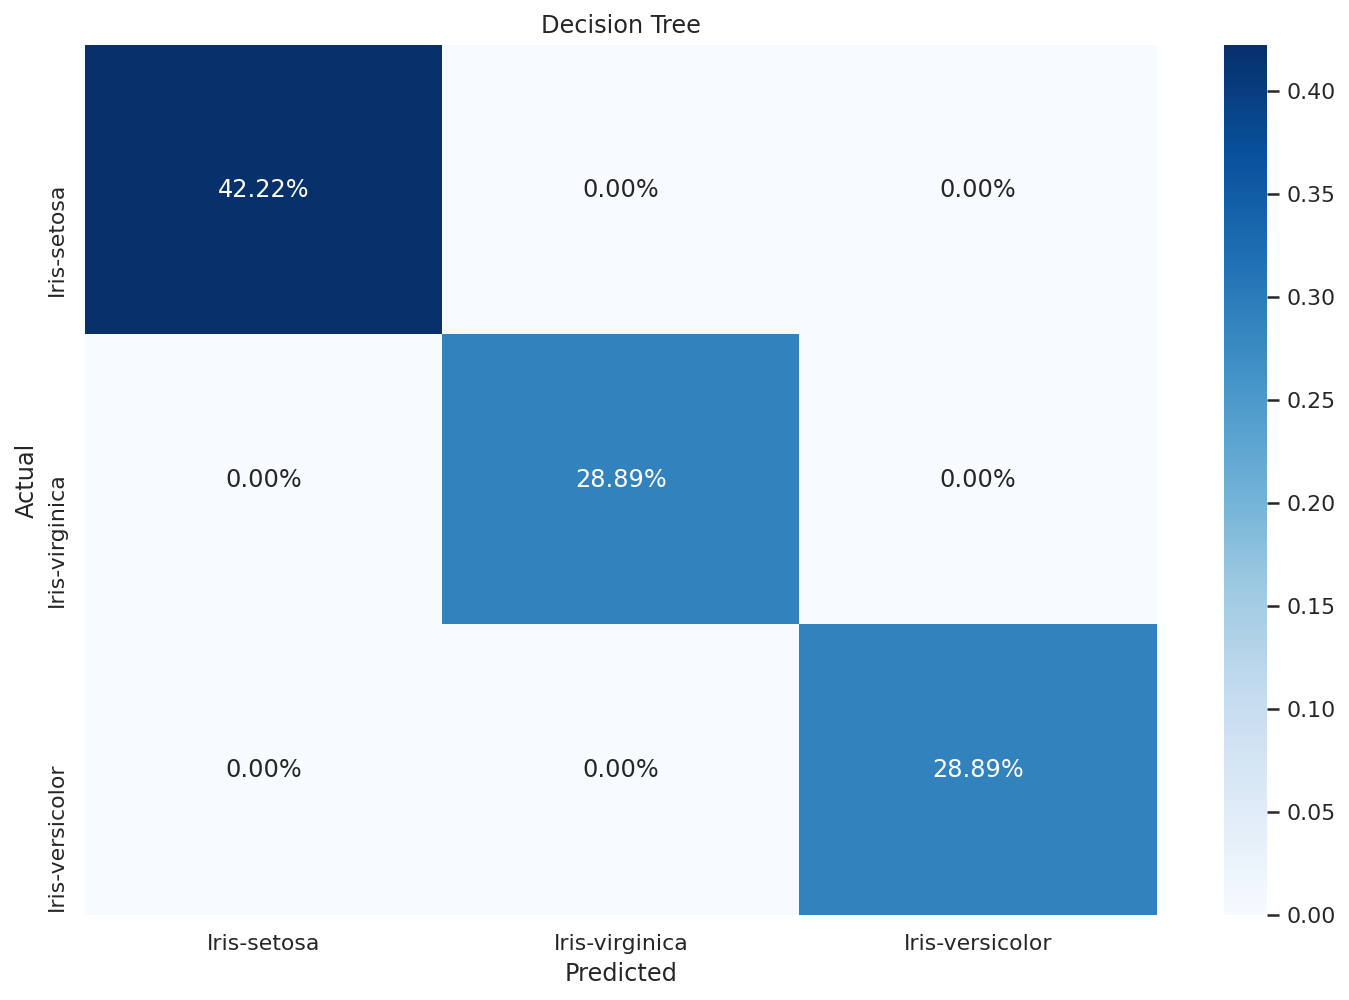

In [72]:
#Let's evaluate the performance of the model
y_pred = trained_dt.predict(X_test_trsf)

# Plot confusion matrix
print('Model F1 Score: %.3f' % f1_score(y_test,y_pred,average='weighted'))

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',xticklabels=['Iris-setosa','Iris-virginica','Iris-versicolor'],
            yticklabels=['Iris-setosa','Iris-virginica','Iris-versicolor'])
plt.title('Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Save Deployment Assets

Once we are satisfied with our model, we will save the trained imputer and trained model to the shared filesystem

In [73]:
# Save our model and scalar
dump(trained_imputer,'../PYUDF/trained_imputer.joblib')
dump(trained_dt,'../PYUDF/trained_dt.joblib')

['../PYUDF/trained_dt.joblib']

#### Model Deployment

Here, we have provided a UDF template for you to fill out.

1. Add some code to load in the trained imputer and scalar (**Hint**: the path where the deployment assets are stored is `home/db2inst1/PYUDF/<file_name>`)
2. Add some code to perform the missing value imputation on the data
3. Add some code to make predictions with the model

In [ ]:
#### SOLUTION #####
%%writefile ../PYUDF/exerciseUDF.py

#Imports
import nzae
import pandas as pd
from joblib import load
import numpy as np


class full_pipeline(nzae.Ae):
    def _runUdtf(self):
        #####################
        ### INITIALIZATON ###
        #####################
        
        # Define static variable
        input_cols=['SEPAL_LENGTH','SEPAL_WIDTH','PETAL_LENGTH','PETAL_WIDTH']
        # Load deployment assets
        
        trained_imputer = #### YOUR CODE HERE ####
        trained_dt = #### YOUR CODE HERE ####
     
        # Collect rows into a single batch
        batchsize = 110
        rownum = 0
        row_list = []
        for row in self:
            row_list.append(row)
            rownum = rownum+1         

            if rownum==batchsize:
                ########################
                ### DATA PREPARATION ###
                ########################
                
                # Collect the rows into a dataframe
                df = pd.DataFrame(row_list, columns=input_cols)

                # Feature imputation
                df_trsf = #### YOUR CODE HERE ####


                ##############################
                ### MODEL SCORING & OUTPUT ###
                ##############################
                
                # Call model to make prediction
                predictions = #### YOUR CODE HERE ####
                
                
                # Return the result
                for x in range(predictions.shape[0]):
                    self.output(float(df_trsf['SEPAL_LENGTH'][x]),
                                float(df_trsf['SEPAL_WIDTH'][x]),
                                float(df_trsf['PETAL_LENGTH'][x]),
                                float(df_trsf['PETAL_WIDTH'][x]),
                                str(predictions[x]))

                row_list = []
                rownum = 0
                
        self.done()
full_pipeline.run()

Now, run the following cells to check your work

In [ ]:
%%sql
CREATE OR REPLACE FUNCTION 
MY_UDF(DOUBLE,DOUBLE,DOUBLE,DOUBLE) 
RETURNS TABLE (SEPAL_LENGTH DOUBLE,
    SEPAL_WIDTH DOUBLE,
    PETAL_LENGTH DOUBLE,
    PETAL_WIDTH DOUBLE,
    PREDICTION VARCHAR(15))
LANGUAGE PYTHON PARAMETER STYLE NPSGENERIC  FENCED  NOT THREADSAFE  NO FINAL CALL  DISALLOW PARALLEL  NO DBINFO  
DETERMINISTIC NO EXTERNAL ACTION CALLED ON NULL INPUT  
NO SQL EXTERNAL NAME 'home/db2inst1/PYUDF/exerciseUDF.py'

In [ ]:
%%sql
DROP TABLE IF EXISTS ONTIME.IRIS_PREDICTIONS

In [ ]:
%%sql
CREATE TABLE ONTIME.IRIS_PREDICTIONS(
    SEPAL_LENGTH DOUBLE,
    SEPAL_WIDTH DOUBLE,
    PETAL_LENGTH DOUBLE,
    PETAL_WIDTH DOUBLE,
    PREDICTION VARCHAR(15))

In [ ]:
%%time
%%sql
INSERT INTO ONTIME.IRIS_PREDICTIONS(SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH,PREDICTION)
SELECT f.* from ONTIME.IRIS_TEST i,
TABLE(MY_UDF(i.SEPAL_LENGTH,i.SEPAL_WIDTH,i.PETAL_LENGTH,i.PETAL_WIDTH)) f

In [ ]:
query = %sql SELECT * FROM ONTIME.IRIS_PREDICTIONS
result = pd.DataFrame(query)
result.head(10)

**SOLUTION**

In [74]:
%%writefile ../PYUDF/exerciseUDF.py

#Imports
import nzae
import pandas as pd
from joblib import load
import numpy as np


class full_pipeline(nzae.Ae):
    def _runUdtf(self):
        #####################
        ### INITIALIZATON ###
        #####################
        
        # Define static variable
        input_cols=['SEPAL_LENGTH','SEPAL_WIDTH','PETAL_LENGTH','PETAL_WIDTH']
        # Load deployment assets
        trained_imputer = load('home/db2inst1/PYUDF/trained_imputer.joblib')
        trained_dt = load('home/db2inst1/PYUDF/trained_dt.joblib')
     
        # Collect rows into a single batch
        batchsize = 110
        rownum = 0
        row_list = []
        for row in self:
            row_list.append(row)
            rownum = rownum+1         

            if rownum==batchsize:
                ########################
                ### DATA PREPARATION ###
                ########################
                
                # Collect the rows into a dataframe
                df = pd.DataFrame(row_list, columns=input_cols)

                # Feature imputation
                df_trsf = pd.DataFrame(trained_imputer.transform(df),columns=input_cols)


                ##############################
                ### MODEL SCORING & OUTPUT ###
                ##############################
                
                # Call model to make prediction
                predictions = trained_dt.predict(df_trsf)
                
                
                # Return the result
                for x in range(predictions.shape[0]):
                    self.output(float(df_trsf['SEPAL_LENGTH'][x]),
                                float(df_trsf['SEPAL_WIDTH'][x]),
                                float(df_trsf['PETAL_LENGTH'][x]),
                                float(df_trsf['PETAL_WIDTH'][x]),
                                str(predictions[x]))

                row_list = []
                rownum = 0
                
        self.done()
full_pipeline.run()

Overwriting ../PYUDF/exerciseUDF.py


In [75]:
%%sql
CREATE OR REPLACE FUNCTION 
MY_UDF(DOUBLE,DOUBLE,DOUBLE,DOUBLE) 
RETURNS TABLE (SEPAL_LENGTH DOUBLE,
    SEPAL_WIDTH DOUBLE,
    PETAL_LENGTH DOUBLE,
    PETAL_WIDTH DOUBLE,
    PREDICTION VARCHAR(15))
LANGUAGE PYTHON PARAMETER STYLE NPSGENERIC  FENCED  NOT THREADSAFE  NO FINAL CALL  DISALLOW PARALLEL  NO DBINFO  
DETERMINISTIC NO EXTERNAL ACTION CALLED ON NULL INPUT  
NO SQL EXTERNAL NAME 'home/db2inst1/PYUDF/exerciseUDF.py'

Command completed.


In [76]:
%%sql
DROP TABLE ONTIME.IRIS_PREDICTIONS

Command completed.


In [77]:
%%sql
CREATE TABLE ONTIME.IRIS_PREDICTIONS(
    SEPAL_LENGTH DOUBLE,
    SEPAL_WIDTH DOUBLE,
    PETAL_LENGTH DOUBLE,
    PETAL_WIDTH DOUBLE,
    PREDICTION VARCHAR(15))

Command completed.


In [78]:
%%time
%%sql
INSERT INTO ONTIME.IRIS_PREDICTIONS(SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH,PREDICTION)
SELECT f.* from ONTIME.IRIS_TEST i,
TABLE(MY_UDF(i.SEPAL_LENGTH,i.SEPAL_WIDTH,i.PETAL_LENGTH,i.PETAL_WIDTH)) f

Command completed.
CPU times: user 1.51 ms, sys: 988 µs, total: 2.5 ms
Wall time: 2.41 s


In [79]:
query = %sql SELECT * FROM ONTIME.IRIS_PREDICTIONS
result = pd.DataFrame(query)
result.head(10)

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH,PREDICTION
0,5.1,3.5,1.400000,0.2,Iris-setosa
1,4.9,3.0,1.400000,0.2,Iris-setosa
2,4.7,3.2,1.300000,0.2,Iris-setosa
3,4.6,3.1,1.500000,0.2,Iris-setosa
4,5.0,3.6,3.917476,0.2,Iris-setosa
5,5.4,3.9,3.917476,0.4,Iris-setosa
6,4.6,3.4,3.917476,0.3,Iris-setosa
7,5.0,3.4,1.500000,0.2,Iris-setosa
8,4.4,2.9,1.400000,0.2,Iris-setosa
9,4.9,3.1,1.500000,0.1,Iris-setosa


## Resources

[Video: Deploying a Machine Learning Model Trained on IBM Cloud Pak for Data into Db2](https://video.ibm.com/recorded/129516812)